In [6]:
# Standard Library Imports
import os
from collections import Counter

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns  # Optional for better color palettes

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE


In [ ]:

import tensorflow_hub as hub
import librosa
import numpy as np
import os
import csv
# Load the YAMNet model from TensorFlow Hub
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Path to the parent directory containing labeled folders
parent_dir = "../data/"

# Mapping labels to integers
label_mapping = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

# Function to extract features using YAMNet
def extract_yamnet_features(audio_path):
    try:
        # Load and resample audio to 16 kHz as required by YAMNet
        waveform, sr = librosa.load(audio_path, sr=16000, mono=True)
        waveform = waveform[:16000 * 10]  # Ensure <=10 seconds

        # Run the audio through YAMNet
        scores, embeddings, spectrogram = yamnet_model(waveform)
        
        # Average embeddings across all time frames
        averaged_embeddings = np.mean(embeddings.numpy(), axis=0)
        return averaged_embeddings
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Output CSV file
output_csv = "yamnet_extracted_features.csv"

# Open CSV file for writing
with open(output_csv, mode='w', newline='', encoding='utf-8') as csvfile:
    # Initialize CSV writer
    fieldnames = [f"YAMNet_Feature_{i+1}" for i in range(1024)] + ["Label"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()  # Write header

    # Loop through each folder and extract features
    for label in os.listdir(parent_dir):
        label_folder = os.path.join(parent_dir, label)
        if os.path.isdir(label_folder):  # Ensure it's a folder
            for file_name in os.listdir(label_folder):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(label_folder, file_name)
                    print(f"Processing: {file_path}")

                    # Extract YAMNet features
                    features = extract_yamnet_features(file_path)
                    if features is not None:
                        # Prepare dictionary for CSV writing
                        feature_dict = {f"YAMNet_Feature_{i+1}": features[i] for i in range(len(features))}
                        feature_dict["Label"] = label_mapping[label.lower()]  # Add label
                        # Write features to CSV
                        writer.writerow(feature_dict)
                    else:
                        print(f"Skipping file due to error: {file_path}")

print(f"Features extracted and directly saved to {output_csv}")


In [4]:
# Load dataset
data = pd.read_csv("../notebooks/yamnet_extracted_features.csv")

# Extract features and labels
feature_columns = [col for col in data.columns if col != 'Label']
X = data[feature_columns]
y = data['Label']  # Assuming 'Label' contains the target emotion labels

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Check the new class distribution
balanced_counts = Counter(y_smote)
print("Class distribution after SMOTE:", balanced_counts)

# Convert back to DataFrame for further processing
X_smote_df = pd.DataFrame(X_smote, columns=feature_columns)
y_smote_df = pd.DataFrame(y_smote, columns=['Label'])

# Combine into a single DataFrame
balanced_data = pd.concat([X_smote_df, y_smote_df], axis=1)

balanced_data.to_csv("balanced_dataset.csv", index=False)
print("Balanced dataset saved to 'balanced_dataset.csv'")

Class distribution after SMOTE: Counter({3: 1017, 5: 1017, 2: 1017, 6: 1017, 4: 1017, 0: 1017, 1: 1017})
Balanced dataset saved to 'balanced_dataset.csv'


In [7]:
data = pd.read_csv("../notebooks/yamnet_balanced.csv")
# Check for missing values
missing_values = sum(data.isnull().sum())
print(f"Missing values: {missing_values}")

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing values: 0
Number of duplicate rows: 1


Applying t-SNE...


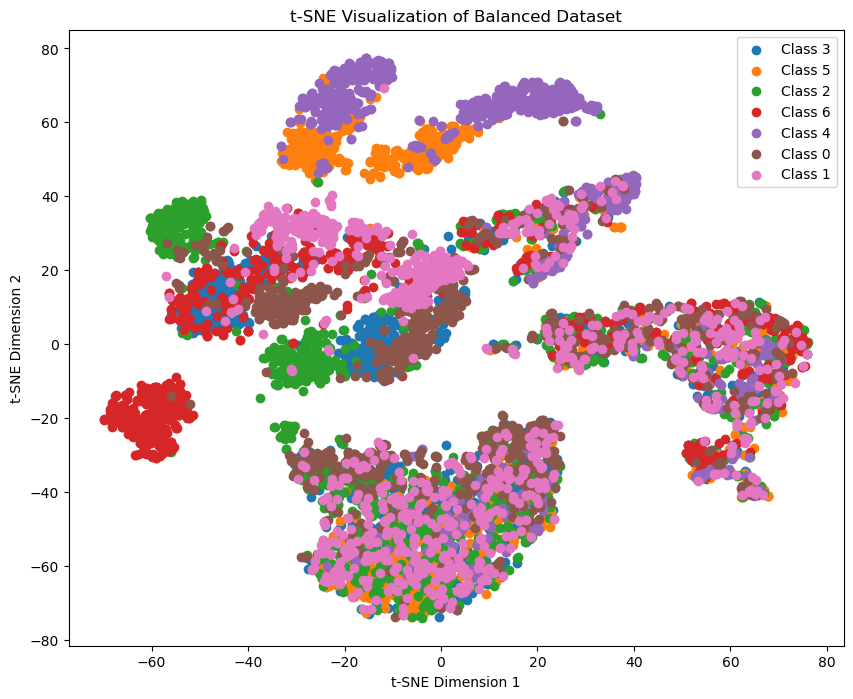

Applying UMAP...


NameError: name 'umap' is not defined

In [ ]:
# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(data)

# Visualize t-SNE
plt.figure(figsize=(10, 8))
for label in balanced_counts.keys():
    plt.scatter(
        X_tsne[y_smote == label, 0],
        X_tsne[y_smote == label, 1],
        label=f"Class {label}"
    )
plt.title("t-SNE Visualization of Balanced Dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()
